In [26]:
import os
import numpy as np
import pandas as pd
import copy
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)

In [148]:
# Defines a TrypanosomaDataset class, that gets images and labels in order from the dataset
class TrypanosomaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filename"]
        label = int(self.df.loc[idx, "label"])

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label
    
class BCEWithLogitsLossLabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        targets = targets * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.bce(logits, targets)
    
aug_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    # geometrical variations 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.85, 1.15),
        shear=5
    ),

    # microscopy variations / contrast
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.05
    ),

    # changes the field of view
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.7, 1.0)
    ),
])

# Saves data augmentation example images. Only for visualization

def gerar_dataset_aumentado(df, output_dir, n_aug=3):
    os.makedirs(output_dir, exist_ok=True)

    novos_dados = []

    for _, row in df.iterrows():
        img = Image.open(row["filename"]).convert("RGB")
        label = row["label"]

        base_name = os.path.splitext(os.path.basename(row["filename"]))[0]

        # imagem original
        orig_path = os.path.join(output_dir, f"{base_name}_orig.png")
        img.save(orig_path)
        novos_dados.append((orig_path, label))

        # imagens aumentadas
        for i in range(n_aug):
            aug_img = aug_transform(img)
            aug_path = os.path.join(output_dir, f"{base_name}_aug{i}.png")
            aug_img.save(aug_path)
            novos_dados.append((aug_path, label))

    return pd.DataFrame(novos_dados, columns=["filename", "label"])

# Defines EarlyStop, a function that stops trainig when no improvement is done

class EarlyStopping:
    def __init__(self, patience=7, min_delta=5e-4, enabled=True):
        """
        patience: how many epochs to wait if val accuracy does not improves
        min_delta: the minimum improvement considered to be relevant
        """
        self.patience = patience
        self.min_delta = min_delta
        self.enabled = enabled
        self.best_loss = np.inf
        self.counter = 0
        self.best_state = None
        self.stop = False

    def __call__(self, val_loss, model):
        
        if not self.enabled:
            return
        
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

# Allows for calculations of accuracy

def binary_accuracy(outputs, labels, threshold=0.5):
    preds = (outputs >= threshold).float()
    correct = (preds == labels).sum().item()
    return correct / labels.numel()

# Creates a test df

def creates_df_test(img_dir, target_file):
    imagens = sorted([
        os.path.join(img_dir, f)
        for f in os.listdir(img_dir)
        if f.endswith(".jpg")
    ],
        key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
)

    labels = np.loadtxt(target_file)

    assert len(imagens) == len(labels), "Number of images ≠ labels"

    return pd.DataFrame({
        "filename": imagens,   
        "label": labels
    })

In [ ]:
# Creates a DataFrame with the directory of each image of the dataset and each label IN THE ORIGINAL ORDER

BASE_DIR = r"D:\Andre\Projeto Trypanossoma\trypanosoma_biomed_v4_compatible"
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train")
VAL_IMG_DIR   = os.path.join(BASE_DIR, "val")

# Lists images in the ORIGINAL ORDER 
train_images = sorted(
    [f for f in os.listdir(TRAIN_IMG_DIR)
     if f.lower().endswith((".png", ".jpg", ".jpeg"))],
    key=lambda x: int(os.path.splitext(x)[0])
)

val_images = sorted(
    [f for f in os.listdir(VAL_IMG_DIR)
     if f.lower().endswith((".png", ".jpg", ".jpeg"))],
    key=lambda x: int(os.path.splitext(x)[0])
)

# Labels (N rows, 1 column)
y_train = np.loadtxt(os.path.join(BASE_DIR, "target_train.txt"))
y_val   = np.loadtxt(os.path.join(BASE_DIR, "target_val.txt"))

# DataFrames 
df_train = pd.DataFrame({
    "filename": [os.path.join(TRAIN_IMG_DIR, f) for f in train_images],
    "label": y_train.astype(int)
})

df_val = pd.DataFrame({
    "filename": [os.path.join(VAL_IMG_DIR, f) for f in val_images],
    "label": y_val.astype(int)
})

print(df_train.head())
print(df_train["label"].value_counts())


                                            filename  label
0  D:\Andre\Projeto Trypanossoma\tripanosoma_biom...      0
1  D:\Andre\Projeto Trypanossoma\tripanosoma_biom...      0
2  D:\Andre\Projeto Trypanossoma\tripanosoma_biom...      1
3  D:\Andre\Projeto Trypanossoma\tripanosoma_biom...      1
4  D:\Andre\Projeto Trypanossoma\tripanosoma_biom...      1
label
1    856
0    816
Name: count, dtype: int64


In [ ]:
# Saves data augmentation example images. Not required for training

df_train_aug = gerar_dataset_aumentado(
    df_train,
    output_dir="train_aug",
    n_aug=9   # cada imagem vira 10 (1 original + 9 aumentadas)
)

print(len(df_train), "→", len(df_train_aug))

1672 → 16720


In [128]:
# DataAugmentation on the fly and Normalization with ImageNet parameters

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    
    # Geometrical Augmentations 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=5
    ),
    
    # Color/Contrast Augmentations 
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.1,
        hue=0.05
    ),
    
    # Final Crop 
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    
    # ImageNet Normalization 
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


In [129]:
# DataLoaders

BATCH_SIZE = 16

train_dataset = TrypanosomaDataset(df_train, transform=train_transform)
val_dataset   = TrypanosomaDataset(df_val,   transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
)


In [130]:
# Load VGG16

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", DEVICE)

model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freezees convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Replaces the original classifier to one with lesser parameters (avoids overfitting)
model.classifier = nn.Sequential(
    nn.Linear(25088, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, 1)
)

model = model.to(DEVICE)

# Loss e optimizer

criterion = BCEWithLogitsLossLabelSmoothing(smoothing=0.1)

optimizer = optim.AdamW(
    model.classifier.parameters(),
    lr=5e-5, weight_decay=1e-4
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=True
)

Usando: cuda


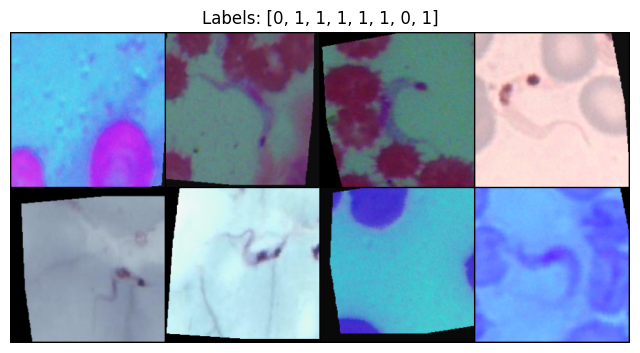

In [ ]:
# Visualize the batch that goes to the model. Works for making sure the labels are correct
# Not necessary to run the model

import torchvision

images, labels = next(iter(train_loader))

# desfaz normalização ImageNet
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

images_vis = images.cpu() * std + mean
images_vis = torch.clamp(images_vis, 0, 1)

grid = torchvision.utils.make_grid(images_vis[:8], nrow=4)

plt.figure(figsize=(8,6))
plt.imshow(grid.permute(1,2,0))
plt.title(f"Labels: {labels[:8].tolist()}")
plt.axis("off")
plt.show()


In [138]:
# Train and validation

EPOCHS = 50

best_val_loss = float('inf')
train_losses = []
val_losses = []
early_stopping = EarlyStopping(
    patience=7,
    min_delta=0.001,
    enabled=True  # Turns it on/off
)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)

    # Training
    
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for images, labels in tqdm(train_loader):
        images = images.to(DEVICE)
        labels = labels.float().to(DEVICE)

        optimizer.zero_grad()

        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc  += binary_accuracy(outputs.detach(), labels)

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Val

    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.float().to(DEVICE)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc  += binary_accuracy(outputs.detach(), labels)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    # Saves the best model 
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'top_model_vgg.pth')
        print(f" Model saved. New best val loss: {val_loss:.4f}")
    
    #Scheduler

    scheduler.step(val_loss)

    # Early stop
    
    early_stopping(val_loss, model)
    if early_stopping.stop:
        print("Early stopping triggered")
        break
    print(f"Train loss: {train_loss:.4f}")
    print(f"Val   loss: {val_loss:.4f}")


if early_stopping.best_state is not None:
    model.load_state_dict(early_stopping.best_state)
    print(f"Best val_loss: {early_stopping.best_loss:.4f}")
else:
    print(" Early stopping deactivated - using the last model")


print(f"\n Best Val Loss: {best_val_loss:.4f}")



Epoch 1/50
------------------------------


100%|██████████| 105/105 [02:15<00:00,  1.29s/it]


 Model saved. New best val loss: 0.3396
Train loss: 0.2996
Val   loss: 0.3396

Epoch 2/50
------------------------------


100%|██████████| 105/105 [02:04<00:00,  1.19s/it]


 Model saved. New best val loss: 0.2974
Train loss: 0.2965
Val   loss: 0.2974

Epoch 3/50
------------------------------


100%|██████████| 105/105 [03:13<00:00,  1.84s/it]


 Model saved. New best val loss: 0.2942
Train loss: 0.2951
Val   loss: 0.2942

Epoch 4/50
------------------------------


100%|██████████| 105/105 [02:01<00:00,  1.16s/it]


Train loss: 0.2771
Val   loss: 0.2950

Epoch 5/50
------------------------------


100%|██████████| 105/105 [02:02<00:00,  1.17s/it]


 Model saved. New best val loss: 0.2852
Train loss: 0.2891
Val   loss: 0.2852

Epoch 6/50
------------------------------


100%|██████████| 105/105 [03:15<00:00,  1.87s/it]


Train loss: 0.2743
Val   loss: 0.2871

Epoch 7/50
------------------------------


100%|██████████| 105/105 [02:50<00:00,  1.62s/it]


Epoch 00016: reducing learning rate of group 0 to 2.5000e-05.
Train loss: 0.2801
Val   loss: 0.2932

Epoch 8/50
------------------------------


100%|██████████| 105/105 [02:45<00:00,  1.58s/it]


 Model saved. New best val loss: 0.2839
Train loss: 0.2844
Val   loss: 0.2839

Epoch 9/50
------------------------------


100%|██████████| 105/105 [01:47<00:00,  1.03s/it]


Train loss: 0.2709
Val   loss: 0.2901

Epoch 10/50
------------------------------


100%|██████████| 105/105 [01:47<00:00,  1.02s/it]


 Model saved. New best val loss: 0.2834
Train loss: 0.2719
Val   loss: 0.2834

Epoch 11/50
------------------------------


100%|██████████| 105/105 [01:47<00:00,  1.02s/it]


 Model saved. New best val loss: 0.2812
Train loss: 0.2775
Val   loss: 0.2812

Epoch 12/50
------------------------------


100%|██████████| 105/105 [02:45<00:00,  1.58s/it]


Train loss: 0.2638
Val   loss: 0.2822

Epoch 13/50
------------------------------


100%|██████████| 105/105 [02:55<00:00,  1.67s/it]


Epoch 00028: reducing learning rate of group 0 to 1.2500e-05.
Train loss: 0.2682
Val   loss: 0.2839

Epoch 14/50
------------------------------


100%|██████████| 105/105 [03:08<00:00,  1.80s/it]


 Model saved. New best val loss: 0.2802
Train loss: 0.2773
Val   loss: 0.2802

Epoch 15/50
------------------------------


100%|██████████| 105/105 [03:07<00:00,  1.79s/it]


 Model saved. New best val loss: 0.2774
Train loss: 0.2657
Val   loss: 0.2774

Epoch 16/50
------------------------------


100%|██████████| 105/105 [01:47<00:00,  1.03s/it]


 Model saved. New best val loss: 0.2766
Train loss: 0.2702
Val   loss: 0.2766

Epoch 17/50
------------------------------


100%|██████████| 105/105 [01:47<00:00,  1.02s/it]


Train loss: 0.2663
Val   loss: 0.2771

Epoch 18/50
------------------------------


100%|██████████| 105/105 [01:47<00:00,  1.02s/it]


Epoch 00038: reducing learning rate of group 0 to 6.2500e-06.
Train loss: 0.2620
Val   loss: 0.2793

Epoch 19/50
------------------------------


100%|██████████| 105/105 [01:47<00:00,  1.03s/it]


Train loss: 0.2615
Val   loss: 0.2793

Epoch 20/50
------------------------------


100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch 00042: reducing learning rate of group 0 to 3.1250e-06.
Train loss: 0.2656
Val   loss: 0.2788

Epoch 21/50
------------------------------


100%|██████████| 105/105 [02:03<00:00,  1.17s/it]


Train loss: 0.2694
Val   loss: 0.2776

Epoch 22/50
------------------------------


100%|██████████| 105/105 [02:04<00:00,  1.18s/it]


 Model saved. New best val loss: 0.2763
Train loss: 0.2628
Val   loss: 0.2763

Epoch 23/50
------------------------------


100%|██████████| 105/105 [03:11<00:00,  1.82s/it]


Train loss: 0.2682
Val   loss: 0.2773

Epoch 24/50
------------------------------


100%|██████████| 105/105 [02:46<00:00,  1.59s/it]


Epoch 00050: reducing learning rate of group 0 to 1.5625e-06.
Train loss: 0.2660
Val   loss: 0.2770

Epoch 25/50
------------------------------


100%|██████████| 105/105 [03:16<00:00,  1.87s/it]


Train loss: 0.2655
Val   loss: 0.2776

Epoch 26/50
------------------------------


100%|██████████| 105/105 [03:16<00:00,  1.87s/it]


Epoch 00054: reducing learning rate of group 0 to 1.0000e-06.
Train loss: 0.2621
Val   loss: 0.2780

Epoch 27/50
------------------------------


100%|██████████| 105/105 [03:09<00:00,  1.80s/it]


Train loss: 0.2627
Val   loss: 0.2771

Epoch 28/50
------------------------------


100%|██████████| 105/105 [03:09<00:00,  1.80s/it]


Train loss: 0.2606
Val   loss: 0.2771

Epoch 29/50
------------------------------


100%|██████████| 105/105 [03:00<00:00,  1.72s/it]


Early stopping triggered
Best val_loss: 0.2763

 Best Val Loss: 0.2763


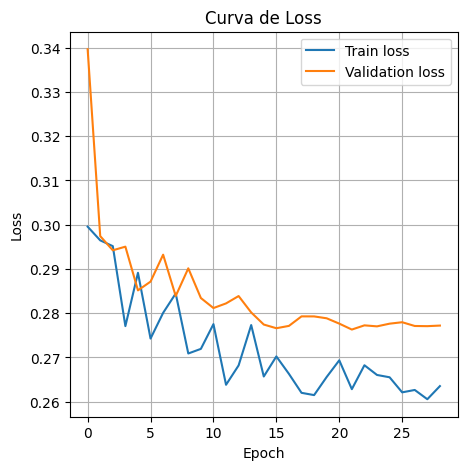

In [139]:
# Plots train and val losses 

plt.figure(figsize=(5,5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de Loss")
plt.legend()
plt.grid(True)
plt.show()

In [140]:
# Evaluates the training of the model 

model.eval()

y_true = []
y_prob = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)

        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)


AUC (validação): 0.9890


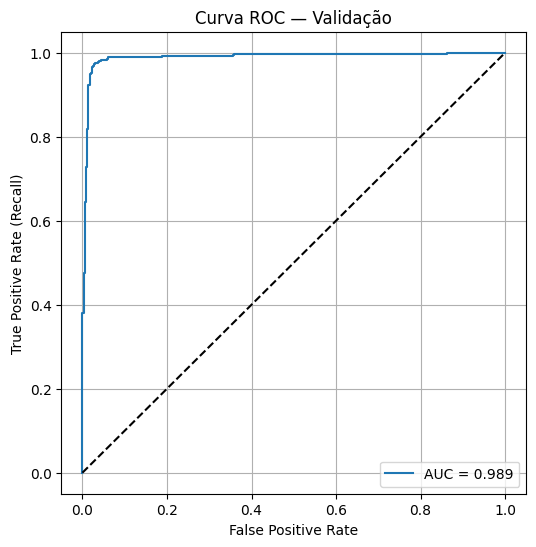

In [141]:
# Validation ROC Curve

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

print(f"AUC (validação): {roc_auc:.4f}")

# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC — Validação")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

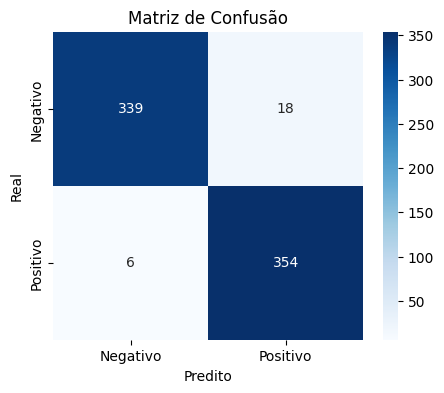

In [142]:
# Confusion Matrix

# Standard threshold
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negativo", "Positivo"],
    yticklabels=["Negativo", "Positivo"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()


In [ ]:
# Creates a test DataFrame woth the images and labels directories 


test_sets = {
    "lamina_18": r"D:\Andre\Projeto Trypanossoma\trypanosoma_biomed_v4_compatible\test\lamina_18\test",
    "lamina_19": r"D:\Andre\Projeto Trypanossoma\trypanosoma_biomed_v4_compatible\test\lamina_19\test",
    "lamina_20": r"D:\Andre\Projeto Trypanossoma\trypanosoma_biomed_v4_compatible\test\lamina_20\test",
    "lamina_23": r"D:\Andre\Projeto Trypanossoma\trypanosoma_biomed_v4_compatible\test\lamina_23\test",
    "lamina_24": r"D:\Andre\Projeto Trypanossoma\trypanosoma_biomed_v4_compatible\test\lamina_24\test",
}

target_files = {
    "lamina_18": r"D:\Andre\Projeto Trypanossoma\trypanosoma_biomed_v4_compatible\test\lamina_18\target_test.txt",
    "lamina_19": r"D:\Andre\Projeto Trypanossoma\trypanosoma_biomed_v4_compatible\test\lamina_19\target_test.txt",
    "lamina_20": r"D:\Andre\Projeto Trypanossoma\trypanosoma_biomed_v4_compatible\test\lamina_20\target_test.txt",
    "lamina_23": r"D:\Andre\Projeto Trypanossoma\trypanosoma_biomed_v4_compatible\test\lamina_23\target_test.txt",
    "lamina_24": r"D:\Andre\Projeto Trypanossoma\trypanosoma_biomed_v4_compatible\test\lamina_24\target_test.txt",
}


In [149]:
 # Tests

# Loads the best model
model.load_state_dict(torch.load('top_model_vgg.pth'))
model.eval()

for name in test_sets.keys():
    print(f"\n=== Evaluating at {name} ===")

    df_test = creates_df_test(
        img_dir=test_sets[name],
        target_file=target_files[name]
    )

    test_dataset = TrypanosomaDataset(
        df_test,
        transform=val_transform
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=0
    )

    model.eval()

    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images).squeeze()
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_pos = tp + fn
    total_neg = tn + fp

    print(f"Acuracy        : {(tp+tn)/(tp+tn+fp+fn):.4f}")
    print(f"Recall (Sens.)  : {tp/(tp+fn):.4f}")
    print(f"Especificidade  : {tn/(tn+fp):.4f}")
    print(f"TP={tp}/{total_pos}, FP={fp}/{total_pos}, TN={tn}/{total_neg}, FN={fn}/{total_neg}")



=== Evaluating at lamina_18 ===
Acuracy        : 0.8625
Recall (Sens.)  : 0.7558
Especificidade  : 0.9865
TP=130/172, FP=2/172, TN=146/148, FN=42/148

=== Evaluating at lamina_19 ===
Acuracy        : 0.9461
Recall (Sens.)  : 0.9885
Especificidade  : 0.9000
TP=86/87, FP=8/87, TN=72/80, FN=1/80

=== Evaluating at lamina_20 ===
Acuracy        : 0.9315
Recall (Sens.)  : 0.9690
Especificidade  : 0.8908
TP=125/129, FP=13/129, TN=106/119, FN=4/119

=== Evaluating at lamina_23 ===
Acuracy        : 0.9783
Recall (Sens.)  : 1.0000
Especificidade  : 0.9576
TP=112/112, FP=5/112, TN=113/118, FN=0/118

=== Evaluating at lamina_24 ===
Acuracy        : 0.9744
Recall (Sens.)  : 0.9978
Especificidade  : 0.9519
TP=457/458, FP=23/458, TN=455/478, FN=1/478
